In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

from IPython import display

In [39]:
path = "rt-polaritydata/rt-polaritydata/"

pos_path = os.path.join(path, 'rt-polarity.pos')
neg_path = os.path.join(path, 'rt-polarity.neg')

def load_review(path, is_pos=True):
    with open(path) as f:
        review = pd.DataFrame({'review':f.read().splitlines()})
    review['sentiment'] = 1 if is_pos else 0
    return review

pos_review = load_review(pos_path, is_pos=True)
neg_review = load_review(neg_path, is_pos=False)

all_reviews = pd.concat([pos_review, neg_review])
all_reviews.head()

,review,sentiment
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1


#### Load word2vec model

In [8]:
from gensim.models import KeyedVectors

word2vec_model = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin/GoogleNews-vectors-negative300.bin", binary=True)

In [16]:
queen = word2vec_model["king"] - word2vec_model["man"] + word2vec_model["woman"]
word2vec_model.similar_by_vector(queen)

[('king', 0.8449392318725586),
 ('queen', 0.7300517559051514),
 ('monarch', 0.6454660892486572),
 ('princess', 0.6156250834465027),
 ('crown_prince', 0.5818676352500916),
 ('prince', 0.577711820602417),
 ('kings', 0.5613664388656616),
 ('sultan', 0.5376776456832886),
 ('Queen_Consort', 0.5344247817993164),
 ('queens', 0.5289887189865112)]

In [140]:
max([len(review) for review in all_reviews.review])

269

#### Process review


In [243]:
from stop_words import get_stop_words

MAX_WORDS = 25
EMBEDDING_SIZE = 300

def process_review(review, max_words=MAX_WORDS):
    review = tf.keras.preprocessing.text.text_to_word_sequence(review)
    review = [word for word in review if word not in get_stop_words('english')]
    review_ = []
    for r in review:
        try:
            review_.append(word2vec_model[r])
        except KeyError:
            review_.append(np.zeros(EMBEDDING_SIZE,)) # when word does not exists in vocab
    while len(review_) < max_words:
        review_.append(np.zeros(EMBEDDING_SIZE,))
    review_ = review_[:max_words]
    return review_

Testing differences between positive and negative review

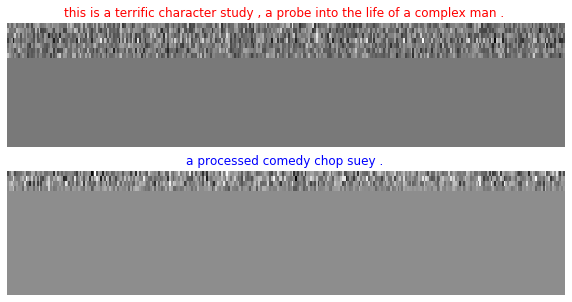

In [244]:
pos = np.random.randint(1000)
neg = np.random.randint(1000)

pos_r = pos_review.review.iloc[pos]
neg_r = neg_review.review.iloc[neg]

pos_review_processed = process_review(pos_r)
neg_review_processed = process_review(neg_r)

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.imshow(pos_review_processed, cmap='gray', interpolation='nearest', aspect='auto')
title = plt.title(pos_r)
plt.setp(title, color='red')
plt.axis('off')

plt.subplot(2, 1, 2)
plt.imshow(neg_review_processed, cmap='gray', interpolation='nearest', aspect='auto')
title = plt.title(neg_r)
plt.setp(title, color='blue')
plt.axis('off')
plt.show()

In [245]:
processed_review = all_reviews.review.apply(lambda review: process_review(review))

In [246]:
from sklearn.model_selection import train_test_split


X = processed_review.to_numpy().tolist()
y = all_reviews.sentiment.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [247]:
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)
X_test = tf.convert_to_tensor(X_test)
y_test = tf.convert_to_tensor(y_test)

In [248]:
X_train_reshaped = tf.reshape(X_train, [X_train.shape[0], X_train.shape[2], X_train.shape[1], 1]) # one channel (black or white)
X_test_reshaped = tf.reshape(X_test, [X_test.shape[0], X_test.shape[2], X_test.shape[1], 1])

In [249]:
X_train_reshaped.shape, X_test_reshaped.shape, y_train.shape, y_test.shape

(TensorShape([9595, 300, 25, 1]),
 TensorShape([1067, 300, 25, 1]),
 TensorShape([9595]),
 TensorShape([1067]))

In [250]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(EMBEDDING_SIZE, MAX_WORDS, 1)),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [251]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 298, 23, 32)       320       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 149, 11, 32)       0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 147, 9, 64)        18496     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 73, 4, 64)         0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 18688)             0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 18688)             0         
_________________________________________________________________
dense_45 (Dense)             (None, 64)              

In [252]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [253]:
BATCH_SIZE = 128

history = model.fit(X_train_reshaped, 
                    y_train, 
                    epochs=30, 
                    batch_size=BATCH_SIZE,
                    validation_data=(X_test_reshaped, y_test))

Train on 9595 samples, validate on 1067 samples
Epoch 1/30
9595/9595 [==============================] - 7s 750us/sample - loss: 0.6930 - accuracy: 0.5137 - val_loss: 0.6925 - val_accuracy: 0.4911
Epoch 2/30
9595/9595 [==============================] - 6s 610us/sample - loss: 0.6799 - accuracy: 0.5728 - val_loss: 0.6645 - val_accuracy: 0.6129
Epoch 3/30
9595/9595 [==============================] - 6s 605us/sample - loss: 0.6307 - accuracy: 0.6482 - val_loss: 0.6071 - val_accuracy: 0.6767
Epoch 4/30
9595/9595 [==============================] - 6s 608us/sample - loss: 0.5773 - accuracy: 0.7012 - val_loss: 0.5805 - val_accuracy: 0.6954
Epoch 5/30
9595/9595 [==============================] - 6s 609us/sample - loss: 0.5487 - accuracy: 0.7232 - val_loss: 0.5694 - val_accuracy: 0.7104
Epoch 6/30
9595/9595 [==============================] - 6s 606us/sample - loss: 0.5265 - accuracy: 0.7352 - val_loss: 0.5635 - val_accuracy: 0.7104
Epoch 7/30
9595/9595 [==============================] - 6s 606us

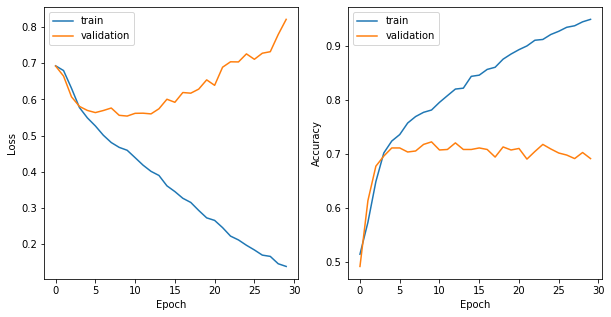

In [254]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [255]:
def predict(review, max_words=MAX_WORDS, shape=(EMBEDDING_SIZE, MAX_WORDS, 1)):
    input_ = [p for p in process_review(review, max_words=max_words)]
    input_ = tf.cast(input_, tf.float32)
    input_ = tf.reshape(input_, shape)
    input_ = input_[np.newaxis, ...]
    prediction = model.predict(input_)[0][0]
    print(prediction)
    if prediction > 0.5:
        print('Positive review with probability: {:.2f}%'.format(prediction * 100))
    else:
        print('Negative review with probability: {:.2f}%'.format(100 - prediction * 100))

In [256]:
predict('this film is amazing. I hope to see it once again in the future.')

0.9832413
Positive review with probability: 98.32%


In [257]:
predict('one of the worse film i have ever seen, do not recommend!')

0.28083625
Negative review with probability: 71.92%


In [258]:
predict("""
Jason Bourne is one of the more intriguing film characters of the past decade
He methodically and purposefully found out who he was, 
who was responsible for his condition, and attempted to bring everything back together again
""")

0.47151434
Negative review with probability: 52.85%


In [259]:
# model.save_weights('models/cnn_words_300x25')